In [1]:
import torch
import requests
from io import BytesIO
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

2026-01-02 11:45:30.375036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767354330.727365      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767354330.821314      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767354331.586921      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767354331.586997      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767354331.587000      55 computation_placer.cc:177] computation placer alr

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", use_fast=True)
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

model = model.to(device)
model.eval()

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [3]:
df = pd.read_csv('/kaggle/input/dataset/Merged_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   subreddit     5223 non-null   object
 1   permalink     5223 non-null   object
 2   score         5223 non-null   int64 
 3   num_comments  5223 non-null   int64 
 4   title         5223 non-null   object
 5   body_text     1205 non-null   object
 6   image_url     2101 non-null   object
dtypes: int64(2), object(5)
memory usage: 285.8+ KB


In [4]:
df.isnull().sum()

subreddit          0
permalink          0
score              0
num_comments       0
title              0
body_text       4018
image_url       3122
dtype: int64

In [5]:
num_df = df.select_dtypes(include='number')
num_df.corr()

,score,num_comments
score,1.000000,0.424796
num_comments,0.424796,1.000000


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

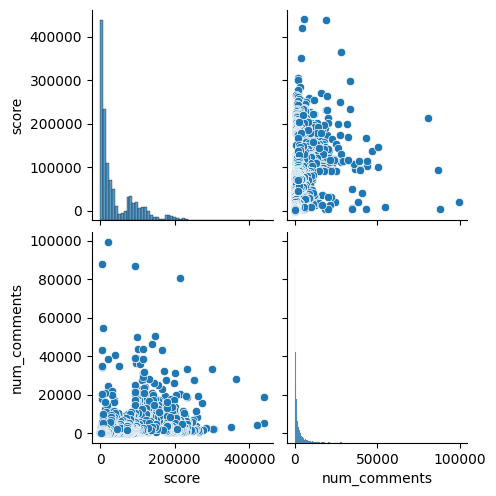

In [6]:
sns.pairplot(num_df)

In [7]:
df["combined_text"] = (df["title"] + " " + df["body_text"].fillna("")).str.strip()

df["combined_text"] = df["combined_text"].str.replace("\n", " ", regex=False)
df.head()

,subreddit,permalink,score,num_comments,title,body_text,image_url,combined_text
0,Medicine,https://old.reddit.com/r/medicine/comments/qzu...,8052,599,A detailed description of how you die from COV...,Good morning.\nI squeeze your hand.\n“It’s Fri...,NaN,A detailed description of how you die from COV...
1,Medicine,https://old.reddit.com/r/medicine/comments/fp2...,4956,356,3 Days of Inpatient Care in New York,NaN,NaN,3 Days of Inpatient Care in New York
2,Medicine,https://old.reddit.com/r/medicine/comments/kb3...,4808,132,Help! A doctor in my hometown was kidnapped by...,NaN,NaN,Help! A doctor in my hometown was kidnapped by...
3,Medicine,https://old.reddit.com/r/medicine/comments/rqx...,4614,405,Powerless [Rant],NaN,NaN,Powerless [Rant]
4,Medicine,https://old.reddit.com/r/medicine/comments/fnz...,4421,335,"Dr. Usama Riaz has spent weeks screening, trea...",NaN,NaN,"Dr. Usama Riaz has spent weeks screening, trea..."


In [8]:
has_image = df["image_url"].notna()

df["cs"] = df["num_comments"]/df["score"]

In [16]:
def get_text_embeddings(text, model, processor, device):
    if text == "":
        return torch.zeros(512)
    inputs = processor(text=[text], return_tensors='pt', padding=True, truncation=True).to(device)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
    text_features = text_features/text_features.norm(dim=-1, keepdim=True)
    return text_features.squeeze().cpu()

def get_image_embeddings(url, model, processor, device):
    if not isinstance(url, str) or url.strip() == "":
        return torch.zeros(512)

    try:
        response = requests.get(url, timeout=5)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content)).convert("RGB")

        inputs = processor(image=image, return_tensors='pt').to(device)
        with torch.no_grad():
            image_features = model.get_image_features(**inputs)

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        return image_features.squeeze().cpu()
    except Exception:
        return torch.zeros(512)

In [12]:
tqdm.pandas()

In [18]:
df["text_embedding"] = df.progress_apply(
    lambda row: get_text_embeddings(
        row["combined_text"],
        model,
        processor,
        device
    ),
    axis=1
)

df["image_embedding"] = df.progress_apply(
    lambda row: get_image_embeddings(
        row["image_url"],
        model,
        processor,
        device
    ),
    axis=1
)


 74%|███████▍  | 3880/5223 [04:30<06:26,  3.47it/s] /usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (174662656 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 75%|███████▌  | 3922/5223 [04:41<04:36,  4.71it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (121484484 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 75%|███████▌  | 3935/5223 [04:45<05:51,  3.66it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (117331669 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 5223/5223 [06:45<00:00, 12.87it/s] 


In [19]:
def combine_embeddings(text_emb, image_emb, alpha=0.5):
    if torch.all(image_emb == 0):
        return text_emb
    return alpha * text_emb + (1 - alpha) * image_emb

df["final_embedding"] = df.progress_apply(
    lambda row: combine_embeddings(
        row["text_embedding"],
        row["image_embedding"]
    ),
    axis=1
)

100%|██████████| 5223/5223 [00:00<00:00, 16311.97it/s]


In [20]:
df.head(10)

,subreddit,permalink,score,num_comments,title,body_text,image_url,combined_text,cs,text_embedding,image_embedding,final_embedding
0,Medicine,https://old.reddit.com/r/medicine/comments/qzu...,8052,599,A detailed description of how you die from COV...,Good morning.\nI squeeze your hand.\n“It’s Fri...,NaN,A detailed description of how you die from COV...,0.074391,"[tensor(-0.0044), tensor(-3.1060e-05), tensor(...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(-0.0044), tensor(-3.1060e-05), tensor(..."
1,Medicine,https://old.reddit.com/r/medicine/comments/fp2...,4956,356,3 Days of Inpatient Care in New York,NaN,NaN,3 Days of Inpatient Care in New York,0.071832,"[tensor(0.0036), tensor(-0.0310), tensor(0.006...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.0036), tensor(-0.0310), tensor(0.006..."
2,Medicine,https://old.reddit.com/r/medicine/comments/kb3...,4808,132,Help! A doctor in my hometown was kidnapped by...,NaN,NaN,Help! A doctor in my hometown was kidnapped by...,0.027454,"[tensor(0.0153), tensor(0.0023), tensor(0.0294...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.0153), tensor(0.0023), tensor(0.0294..."
3,Medicine,https://old.reddit.com/r/medicine/comments/rqx...,4614,405,Powerless [Rant],NaN,NaN,Powerless [Rant],0.087776,"[tensor(-0.0222), tensor(0.0221), tensor(0.015...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(-0.0222), tensor(0.0221), tensor(0.015..."
4,Medicine,https://old.reddit.com/r/medicine/comments/fnz...,4421,335,"Dr. Usama Riaz has spent weeks screening, trea...",NaN,NaN,"Dr. Usama Riaz has spent weeks screening, trea...",0.075775,"[tensor(0.0112), tensor(-0.0295), tensor(0.026...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.0112), tensor(-0.0295), tensor(0.026..."
5,Medicine,https://old.reddit.com/r/medicine/comments/flk...,4397,397,There is no emergency in a pandemic,NaN,NaN,There is no emergency in a pandemic,0.090289,"[tensor(0.0153), tensor(0.0004), tensor(0.0157...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.0153), tensor(0.0004), tensor(0.0157..."
6,Medicine,https://old.reddit.com/r/medicine/comments/1md...,4331,156,"Today, I was a hero",A family came in with their 2mo. And they wer...,NaN,"Today, I was a hero A family came in with thei...",0.036019,"[tensor(0.0159), tensor(-0.0015), tensor(-0.02...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.0159), tensor(-0.0015), tensor(-0.02..."
7,Medicine,https://old.reddit.com/r/medicine/comments/j72...,4289,136,My residency program thinks very highly of me ...,NaN,https://i.redd.it/8o7uo43mdrr51.jpg,My residency program thinks very highly of me ...,0.031709,"[tensor(0.0223), tensor(0.0085), tensor(0.0083...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.0223), tensor(0.0085), tensor(0.0083..."
8,Medicine,https://old.reddit.com/r/medicine/comments/ff8...,4163,510,"Testimony of a surgeon working in Bergamo, in ...",«In one of the non-stop e-mails that I receive...,NaN,"Testimony of a surgeon working in Bergamo, in ...",0.122508,"[tensor(0.0017), tensor(-0.0006), tensor(0.047...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.0017), tensor(-0.0006), tensor(0.047..."
9,Medicine,https://old.reddit.com/r/medicine/comments/f7t...,4137,247,Scrubbing into a CABG with your mom as your at...,NaN,https://i.imgur.com/OI6QV37.jpg,Scrubbing into a CABG with your mom as your at...,0.059705,"[tensor(-0.0159), tensor(0.0094), tensor(-0.02...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(-0.0159), tensor(0.0094), tensor(-0.02..."
